# 单样本学习和孪生网络
ONE SHOT LEARNING（单样本学习） WITH SIAMESE NETWORKS （孪生网络）

假设公司有10个人的照片，传统思路是训练一个十分类的网络。但是，如果公司增加新员工或者有员工离职了，网络重训？

新的思路： 公司有员工A,B,  用A的两张照片构造一个正样本，用A,B各一张照片构造一个负样本，输入就是两张照片和正负标签，两张照片都过同一个模型产生2个向量，将两个向量得到一个相似度得分，通常用softmax函数将这个得分进行压缩。0表示完全不相似，1表示完全相似，转换成一个二分类问题。
模型训练完成后，将公司所有人的照片过下模型得到每个人人脸照片的向量表示，新来员工则在员工人脸向量库中增加该人的人脸向量即可。当员工刷脸时，过一遍模型得到人脸向量，再和数据库中向量比对，找到最近的那个作为最匹配的。

除了人脸识别的应用场景外，尝试挖掘一些比较稀少的低质样本。只要人工标注发现一类低质样本，将该低质样本过模型得到向量存入向量库，再去找没有标注的数据哪些跟该样本相似，用于增广该类低质样本，是的最终训练的样本保持均衡。

* https://zhuanlan.zhihu.com/p/35040994
* https://github.com/adambielski/siamese-triplet
* https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch/blob/master/Siamese-networks-medium.ipynb

In [1]:
import numpy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F


# 1. 定义模型
class SiameseModel(nn.Module):
    def __init__(self, input_dim,output_dim=8):
        super(SiameseModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 25),
            nn.ReLU(),
            nn.Linear(25, 30),
            nn.ReLU(),
            nn.Linear(30, output_dim)
        )

    def forward(self, input1, input2):
        v1 = self.model(input1)
        v2 = self.model(input2)
#         out = v1 - v2 
        return v1,v2
    
    def predict(self, input0):
        # 实际预测的时候，只需要输入一个，得到得分即可
        return self.model(input0)

# 模型初始化
input_dim = 4
output_dim = 8 #
model = SiameseModel(input_dim,output_dim)

# 模型简单测试
batch_size = 2
input1 = torch.rand(batch_size,input_dim)
input2 = torch.rand(batch_size,input_dim)
ret = model(input1,input2)
print(ret)
input0 = torch.rand(1,input_dim)
ret0 = model.predict(input0)
print(ret0)

(tensor([[ 0.1675,  0.1254, -0.1997, -0.1224, -0.0815,  0.0223,  0.1118, -0.0283],
        [ 0.1791,  0.1299, -0.2088, -0.1007, -0.0982,  0.0162,  0.1128,  0.0007]],
       grad_fn=<AddmmBackward>), tensor([[ 0.1699,  0.1224, -0.2072, -0.0944, -0.0685, -0.0172,  0.0924, -0.0622],
        [ 0.2047,  0.1322, -0.1831, -0.0924, -0.0988,  0.0184,  0.0962,  0.0227]],
       grad_fn=<AddmmBackward>))
tensor([[ 0.1664,  0.1250, -0.2121, -0.1156, -0.0835,  0.0174,  0.1190, -0.0162]],
       grad_fn=<AddmmBackward>)


In [2]:
# 2. 自定义损失函数
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9
    
    def forward(self, output1, output2, target, size_average=True): 
        """两个向量直接减, 实际测试loss可收敛"""
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
#         distances = F.pairwise_distance(output1, output2, keepdim = True) # euclidean distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

#     def forward(self, output1, output2, label):
#         """两个向量cosin距离，实际测试loss不收敛？"""
#         distances = F.pairwise_distance(output1, output2, keepdim = True) # euclidean distance
# #         distances = (output2 - output1).pow(2).sum(1)
#         # 下面这行似乎有问题？
#         losses = (1-label) * torch.pow(distances, 2) + \
#             (label) * torch.pow(torch.clamp(self.margin - distances, min=0.0), 2)
#         return torch.mean(losses)

# test

In [3]:
# 3. 数据集预处理，相同分类的pair为正样本，不同分类的pair为负样本
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class IrisDataset(Dataset):
    def __init__(self,data_type="train"):
        assert data_type in ('train','test')
        self.labels = {'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2}
        self.pd_frame = pd.read_csv("./dataset/iris/%s.csv" % (data_type),header=None)
        self.dataset = list(self.gen_pairs())

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def gen_pairs(self): 
        cnt = len(self.pd_frame)
        for i in range(cnt-1):
            i_label = self.pd_frame.iloc[i, 4]
            i_X = self.pd_frame.iloc[i, 0:4]
            for j in range(i+1,cnt):
                j_label = self.pd_frame.iloc[j, 4]
                j_X = self.pd_frame.iloc[j, 0:4] 
                yield 1.0 if i_label==j_label else 0,i_X.to_numpy(np.float32),j_X.to_numpy(np.float32)
            
#测试数据集
dataset = IrisDataset() #
label,x1,x2 = next(iter(dataset))
print(label,x1,x2)

train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
train_labels,train_features1,train_features2 = next(iter(train_dataloader))
# print(train_labels,train_features1,train_features2)
print(f"Labels batch shape: {train_labels.size()}")
print(f"Feature1 batch shape: {train_features1.size()}")
print(f"Feature2 batch shape: {train_features2.size()}")
# print(train_dataloader.batch_size)



1.0 [7.6 3.  6.6 2.1] [6.9 3.1 5.4 2.1]
Labels batch shape: torch.Size([64])
Feature1 batch shape: torch.Size([64, 4])
Feature2 batch shape: torch.Size([64, 4])


Epoch:0 batch:0 loss:0.940151035785675 
Epoch:0 batch:9 loss:0.6913157105445862 
Epoch:1 batch:0 loss:0.6381360292434692 
Epoch:1 batch:9 loss:0.3607829809188843 
Epoch:2 batch:0 loss:0.38604989647865295 
Epoch:2 batch:9 loss:0.16247235238552094 
Epoch:3 batch:0 loss:0.21776190400123596 
Epoch:3 batch:9 loss:0.20620711147785187 
Epoch:4 batch:0 loss:0.23811917006969452 
Epoch:4 batch:9 loss:0.15145206451416016 
Epoch:5 batch:0 loss:0.10913698375225067 
Epoch:5 batch:9 loss:0.23343323171138763 
Epoch:6 batch:0 loss:0.07452350854873657 
Epoch:6 batch:9 loss:0.08197259902954102 
Epoch:7 batch:0 loss:0.19631728529930115 
Epoch:7 batch:9 loss:0.10484776645898819 
Epoch:8 batch:0 loss:0.15678831934928894 
Epoch:8 batch:9 loss:0.13326188921928406 
Epoch:9 batch:0 loss:0.1668071746826172 
Epoch:9 batch:9 loss:0.07453184574842453 
Epoch:10 batch:0 loss:0.1294322907924652 
Epoch:10 batch:9 loss:0.12433502078056335 
Epoch:11 batch:0 loss:0.13758789002895355 
Epoch:11 batch:9 loss:0.11600666493177

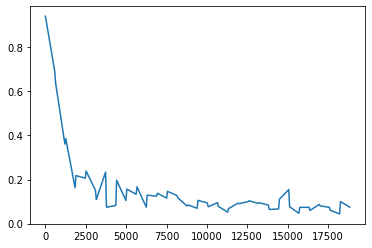

In [4]:
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)


counter = []
loss_history = [] 
def train(epoch,dataloader, model, loss_fn, optimizer):
    model.train() #训练模式
    
    dataset_cnt = len(dataloader.dataset)
    batch_cnt = len(dataloader)
#     print(dataset_size,batch_size) 
    
    for batch, (label,x1,x2) in enumerate(dataloader): 
        output1,output2 = model(x1,x2)
        loss_contrastive = criterion(output1,output2,label)
        optimizer.zero_grad()
        loss_contrastive.backward()
        optimizer.step()
        if batch % 10 == 0 or batch==(batch_cnt-1):
            print("Epoch:{} batch:{} loss:{} ".format(epoch,batch,loss_contrastive.item()))
            iteration_number = epoch*dataset_cnt + dataloader.batch_size * batch
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item()) 

epochs = 30
for epoch in range(epochs): 
    train(epoch,train_dataloader, model, criterion, optimizer)
#     test(test_dataloader, model, criterion)

torch.save(model, 'siamese_module.pth')

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()
show_plot(counter,loss_history)


In [5]:
class IrisPredictDataset(Dataset):
    def __init__(self,data_type="train"):
        assert data_type in ('train','test')
        self.labels = {'Iris-setosa':0,'Iris-versicolor':1,'Iris-virginica':2}
        self.pd_frame = pd.read_csv("./dataset/iris/%s.csv" % (data_type),header=None)

    def __len__(self):
        return len(self.pd_frame)

    def __getitem__(self, idx):
        label = self.pd_frame.iloc[idx, 4]
        X = self.pd_frame.iloc[idx, 0:4]
        return X.to_numpy(np.float32),self.labels[label]

train1_dataloader = DataLoader(IrisPredictDataset("train"), batch_size=64)
test1_dataloader = DataLoader(IrisPredictDataset("test"), batch_size=64)
train_x,train_label = next(iter(train1_dataloader))
test_x,test_label = next(iter(test1_dataloader))

In [6]:
model_x = torch.load('siamese_module.pth')

# 输出向量结果
def compute_vector(model,dataloader):
    def compute():
        model.eval()
        batch_cnt = len(dataloader) 
        for batch, (x1,label) in enumerate(dataloader): 
            #其实不需要训练，直接用iris原始的特征计算相似度也能到93%。
            #孪生网络对于图像，文本作用更好些
#             for i,r in enumerate(x1): 
#                 yield torch.tensor([label[i]]),r
            ret = model.predict(x1) 
            for i,r in enumerate(ret):
                yield torch.tensor([label[i]]),r
                
    l = list(compute())
    labels = torch.stack([label for label,vec in l],0) #cat和stack的区别
    vectors = torch.stack([vec for label,vec in l],0)
    return labels,vectors

train_label,train_vecotors = compute_vector(model_x,train1_dataloader)
test_label,test_vecotors = compute_vector(model_x,test1_dataloader)


# https://pytorch.org/docs/stable/generated/torch.cdist.html
matrix_dist = torch.cdist(test_vecotors, train_vecotors,  p=2)
min_idxs = matrix_dist.argmin(dim=1) #距离最小的那个 topk,最小的n个
most_close_sampe = train_label.index_select(0,min_idxs)
print(most_close_sampe.shape,test_label.shape)
auc = (most_close_sampe==test_label).sum()*100/test_label.shape[0]
print(auc)
# print(most_close_sampe)
# print(test_label)
print(most_close_sampe[:,0].eq(test_label[:,0]))

# 调整训练集大小
# train:120 acc=96.67%
# train:12 acc=83.33%
# train:24 acc=86.67 ~ 93.33%
# train:36 acc=93.33 ~ 96.67%  (分类模型，60.0%)


torch.Size([30, 1]) torch.Size([30, 1])
tensor(96.6667)
tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True])
